# 1. Setup

In [1]:
import os
import shutil
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

from model import UNet, EAST

In [2]:
with open('config.yaml', 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
print(config)

{'data': {'dir': 'Data/Detection-Big', 'height': 320, 'width': 320, 'channels': 3, 'geometry_scale_factor': 64}, 'model': {'name': 'EAST', 'geometry': 'AABB', 'with_classification': False}, 'training': {'info': '', 'batch_size': 32, 'score_weights_auto': True, 'score_weights_woc': [1, 10], 'score_weights_wc': [1, 10, 10, 10, 10], 'lambda_score': 1, 'lambda_geometry': 1, 'lr': 0.001, 'lr_step_size': 5, 'lr_gamma': 0.5, 'weight_decay': 0.001, 'num_epochs': 30}, 'prediction': {'model_path': 'Models/EAST-Detector-e12.pth', 'device': 'cuda', 'batch_size': 4, 'score_threshold': 0.85, 'iou_threshold': 0.2}, 'evaluation': {'predictions_dir_name': 'Annotations-AABB-Pred-EAST-0.85-0.2', 'iou_threshold': 0.7}}


In [3]:
train_dir = os.path.join(config['data']['dir'], 'Train')
val_dir = os.path.join(config['data']['dir'], 'Val')
test_dir = os.path.join(config['data']['dir'], 'Test')
print(train_dir, val_dir, test_dir)

Data/Detection-Big/Train Data/Detection-Big/Val Data/Detection-Big/Test


In [4]:
num_cpus = os.cpu_count()
print(num_cpus)
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = config['prediction']['device']
device = torch.device(device)
print(device)

8
cuda


In [5]:
image_height = config['data']['height']
image_width = config['data']['width']
geometry_scale_factor = config['data']['geometry_scale_factor']

# 2. Define Dataset

In [6]:
class DetectionDatasetX(Dataset):
    
    def __init__(self, data_dir, geometry, with_classification):
        self.data_dir = data_dir
        self.geometry = geometry
        self.with_classification = with_classification
        self.height = config['data']['height']
        self.width = config['data']['width']
        self.image_dir = os.path.join(self.data_dir, 'Images')
        self.ann_dir = os.path.join(self.data_dir, f'Annotations-{geometry}')
        self.image_fns = os.listdir(self.image_dir)
        self.lang2id = {'Tamil':1, 'Hindi':2, 'Telugu':3, 'Malayalam':4, 'Punjabi':5, 'English':6}
        self.id2lang = {v:k for k,v in self.lang2id.items()}
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        self.image_fn = image_fn
        image_fp = os.path.join(self.image_dir, image_fn)
        image = cv2.imread(image_fp)
        x = self.image_transform(image)
        
        return x, image_fn
    
    def image_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)
    
    def image_transform_inverse(self, transformed_image):
        transform_ops = transforms.Compose([
            transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
        ])
        return transform_ops(transformed_image)

# 3. Load model

In [7]:
model_name = config['model']['name']
geometry = config['model']['geometry']
with_classification = config['model']['with_classification']

if model_name == 'UNet':
    model = UNet(image_width=image_width,
                 geometry=geometry, 
                 with_classification=with_classification)
elif model_name == 'EAST':
    model = EAST(image_width=image_width, 
                 geometry=geometry, 
                 with_classification=with_classification)

In [8]:
model_path = config['prediction']['model_path']
if config['prediction']['device'] == 'cpu':
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    model.load_state_dict(torch.load(model_path))
    model = nn.DataParallel(model)
    model = model.to(device)

In [9]:
model = model.eval()

# 4. Define ultils

In [10]:
# Code Reference: https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
    """
    boxes : np.array of shape(n, 4)
        array of top-left and bottom right points
    overlapThresh : float
     maximum overlap iou allowed
    """
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

# 4. Make predictions

In [11]:
batch_size = config['prediction']['batch_size']

trainset = DetectionDatasetX(train_dir, geometry=geometry, with_classification=with_classification)
valset = DetectionDatasetX(val_dir, geometry=geometry, with_classification=with_classification)
testset = DetectionDatasetX(test_dir, geometry=geometry, with_classification=with_classification)
print(len(trainset), len(valset), len(testset))

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=num_cpus)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_cpus)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_cpus)
print(len(train_loader), len(val_loader), len(test_loader))

55000 1200 1200
13750 300 300


In [12]:
score_threshold = config['prediction']['score_threshold']
iou_threshold = config['prediction']['iou_threshold']
print(score_threshold, iou_threshold)

0.85 0.2


In [13]:
def make_predictions(split='Test'):
    
    data_dir = os.path.join(config['data']['dir'], split)
    if split == 'Test':
        data_loader = test_loader
    elif split == 'Val':
        data_loader = val_loader
    elif split == 'Train':
        data_loader = train_loader
        
    ann_pred_dir = f'{data_dir}/Annotations-AABB-Pred-{model_name}-{score_threshold}-{iou_threshold}'
    if os.path.exists(ann_pred_dir):
        shutil.rmtree(ann_pred_dir)
    os.mkdir(ann_pred_dir)
        
    with torch.no_grad():
        
        for X, image_fns in tqdm(data_loader, desc=f'{split}-set Prediction'):
            X = X.to(device)
            Y_score_pred_logits, Y_geometry_pred, _ = model.forward(X)
            Y_geometry_pred = Y_geometry_pred * config['data']['geometry_scale_factor']
            if with_classification:
                Y_score_pred = torch.softmax(Y_score_pred_logits, dim=1)
                Y_class_pred = torch.argmax(Y_score_pred, dim=1)
                Y_score_pred = torch.sum(Y_score_pred[:, 1:, :, :], dim=1) # add text class probabilties for each lang
            else:
                Y_score_pred = torch.sigmoid(Y_score_pred_logits)
                Y_score_pred = torch.squeeze(Y_score_pred, dim=1)
                
            for i in range(batch_size):
            #for i in tqdm(range(batch_size), leave=False):
                y_score_pred = Y_score_pred[i] # [h, w]
                y_geometry_pred = Y_geometry_pred[i] # [4, h, w]
                y_geometry_pred = y_geometry_pred.permute(1, 2, 0) # [h, w, 4] 
                mask = y_score_pred >= score_threshold

                indices = torch.nonzero(mask) # [n, 2]
                geometries = y_geometry_pred[mask] # [n, 4]
                if model_name == 'EAST':
                    indices = indices * 4 # region proposal indices in original image dimensions
                    geometries = geometries * 4

                top_left_yx = indices - geometries[:, [1,0]] # [n, 2]
                bottom_right_yx = indices + geometries[:, [3,2]] # [n, 2]
                boxes_yx = torch.cat((top_left_yx, bottom_right_yx), dim=1) # [n, 4]
                boxes = boxes_yx[:, [1, 0, 3, 2]] # [y1, x1, y2, x2] -> [x1, y1, x2, y2]
                boxes[:, [0, 2]] = torch.clamp(boxes[:, [0, 2]], min=0, max=image_width)
                boxes[:, [1, 3]] = torch.clamp(boxes[:, [1, 3]], min=0, max=image_height)
                boxes = boxes.detach().cpu().numpy()
                #width_height = bottom_right - top_left # [n, 2]
                #areas = width_height[:, 0] * width_height[:, 1] # [n, 1]

                boxes = non_max_suppression_fast(boxes, overlapThresh=iou_threshold)
                boxes = pd.DataFrame(boxes, columns=['x', 'y', 'w', 'h'])
                boxes['w'] = boxes['w'] - boxes['x']
                boxes['h'] = boxes['h'] - boxes['y']
                
                ann_fn = f'{image_fns[i].split(".")[0]}.csv'
                ann_fp = os.path.join(ann_pred_dir, ann_fn)
                boxes.to_csv(ann_fp, index=False)

In [14]:
make_predictions(split='Test')

In [15]:
make_predictions(split='Val')

In [16]:
make_predictions(split='Train')

# 5. Visualise Predictions

In [17]:
def visualize_predictions(split='Test', n=10):
    
    data_dir = os.path.join(config['data']['dir'], split)
    if split == 'Test':
        dataset = testset
    elif split == 'Val':
        dataset = valset
    elif split == 'Train':
        dataset = trainset
    
    img_dir = f'{data_dir}/Images'
    ann_dir = f'{data_dir}/Annotations-AABB'
    
    cnt = 0
        
    with torch.no_grad():
        
        indices = np.random.choice(range(len(dataset)), n)
        for index in indices:
            X, _ = dataset[index]
            X = torch.unsqueeze(X, 0)
            Y_score_pred_logits, Y_geometry_pred, _ = model.forward(X)
            Y_geometry_pred = Y_geometry_pred * config['data']['geometry_scale_factor']
            if with_classification:
                Y_score_pred = torch.softmax(Y_score_pred_logits, dim=1)
                Y_class_pred = torch.argmax(Y_score_pred, dim=1)
                Y_score_pred = torch.sum(Y_score_pred[:, 1:, :, :], dim=1) # add text class probabilties for each lang
            else:
                Y_score_pred = torch.sigmoid(Y_score_pred_logits)
                Y_score_pred = torch.squeeze(Y_score_pred, dim=1)
                
            image_actual = dataset.image_transform_inverse(X[0])
            image_actual = image_actual.permute(1, 2, 0).cpu().numpy()
            image_actual = cv2.cvtColor(image_actual, cv2.COLOR_BGR2RGB)
            y_score_pred = Y_score_pred[0].cpu().numpy() # [h, w]
            mask = y_score_pred >= 0.5
            score_map = (mask).astype(np.uint)
            
            geometry_left = Y_geometry_pred[0, 0].cpu().numpy()
            geometry_left[~mask] = 0
            geometry_top = Y_geometry_pred[0, 1].cpu().numpy()
            geometry_top[~mask] = 0
            geometry_right = Y_geometry_pred[0, 2].cpu().numpy()
            geometry_right[~mask] = 0
            geometry_bottom = Y_geometry_pred[0, 3].cpu().numpy()
            geometry_bottom[~mask] = 0
            
            fig, axes = plt.subplots(2, 4, figsize=((64//4, 32//4)))
            axes[0][0].imshow(image_actual)
            axes[0][1].imshow(y_score_pred, cmap='gray')
            axes[0][2].imshow(score_map, cmap='gray')
            axes[0][3].imshow(image_actual)
            axes[1][0].imshow(geometry_left, cmap='gray')
            axes[1][1].imshow(geometry_top, cmap='gray')
            axes[1][2].imshow(geometry_right, cmap='gray')
            axes[1][3].imshow(geometry_bottom, cmap='gray')
            plt.show()

            cnt += 1 
            if cnt >= n:
                return True
                

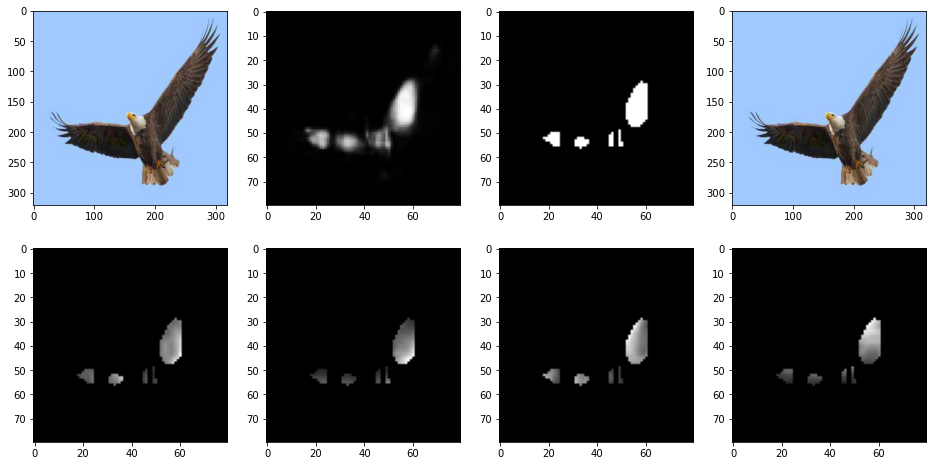

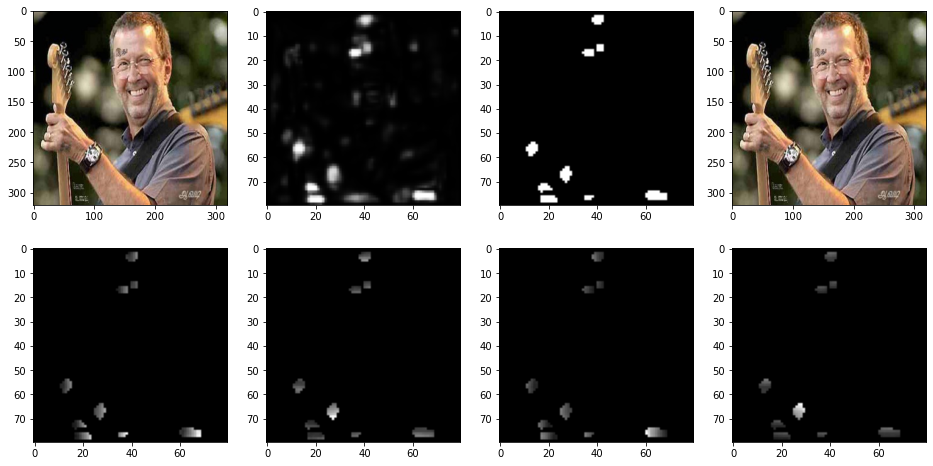

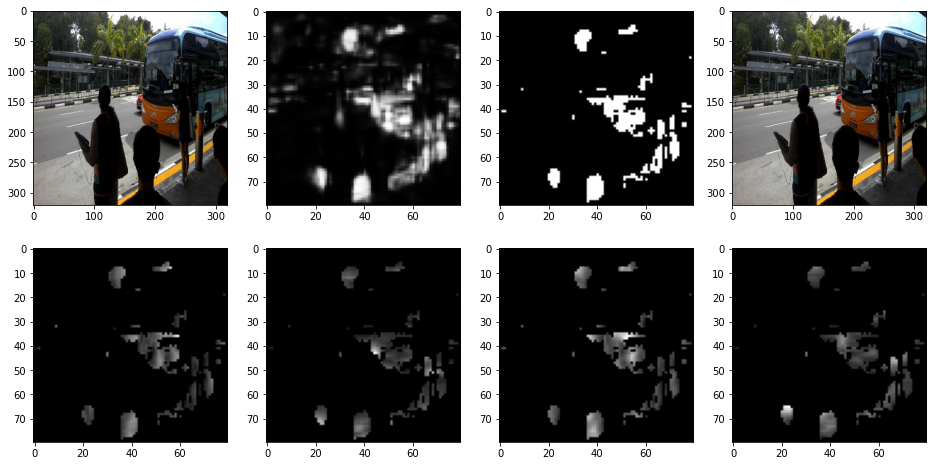

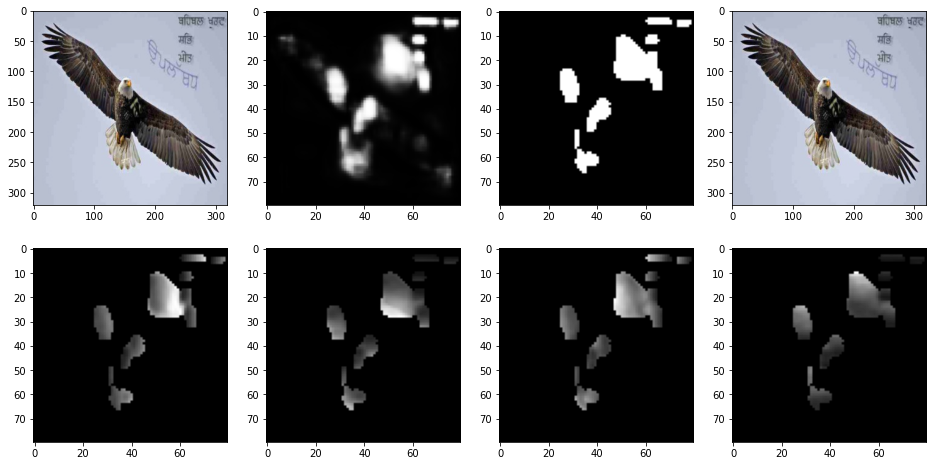

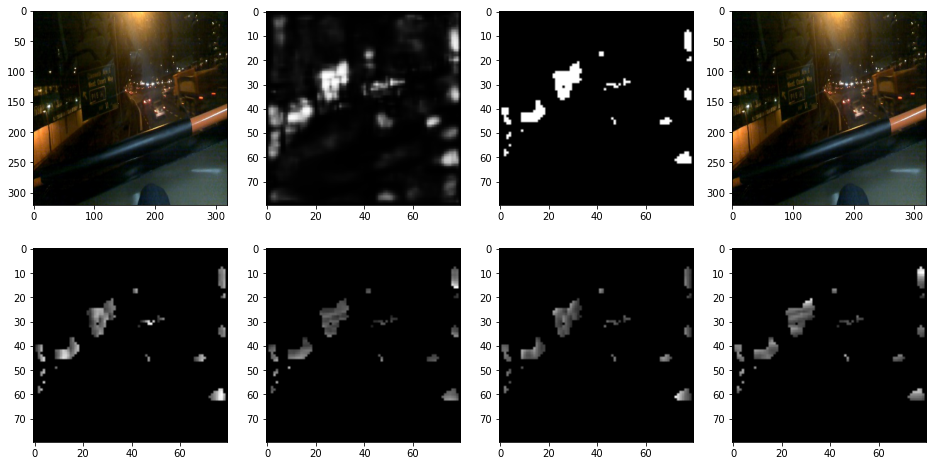

True

In [18]:
visualize_predictions(split='Test', n=5)

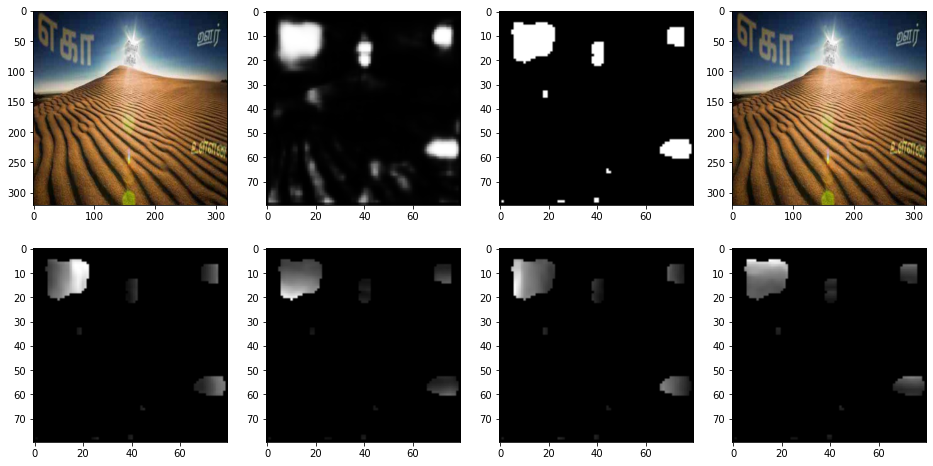

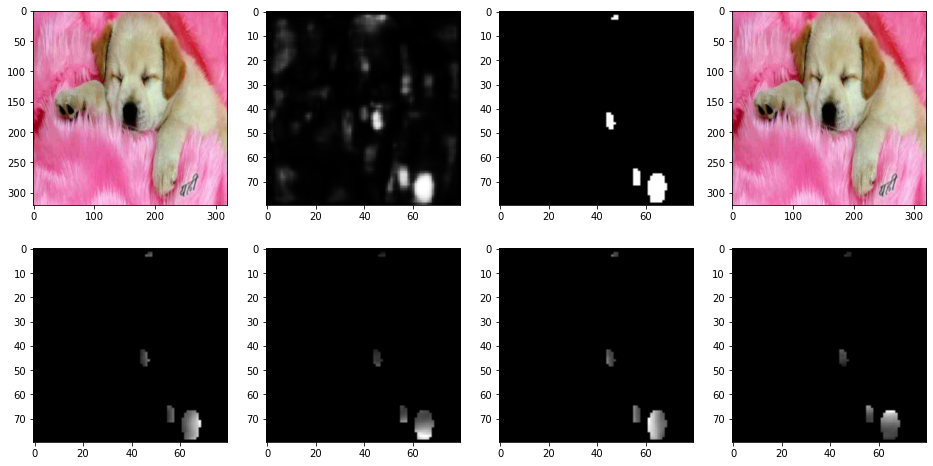

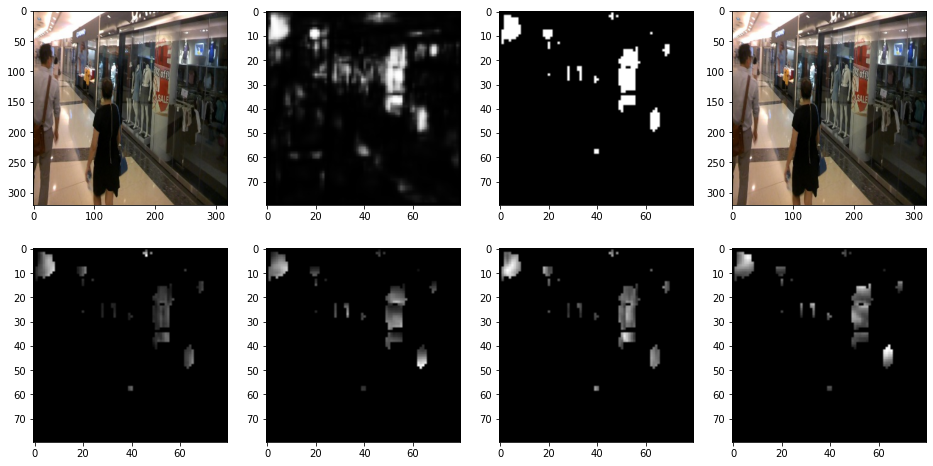

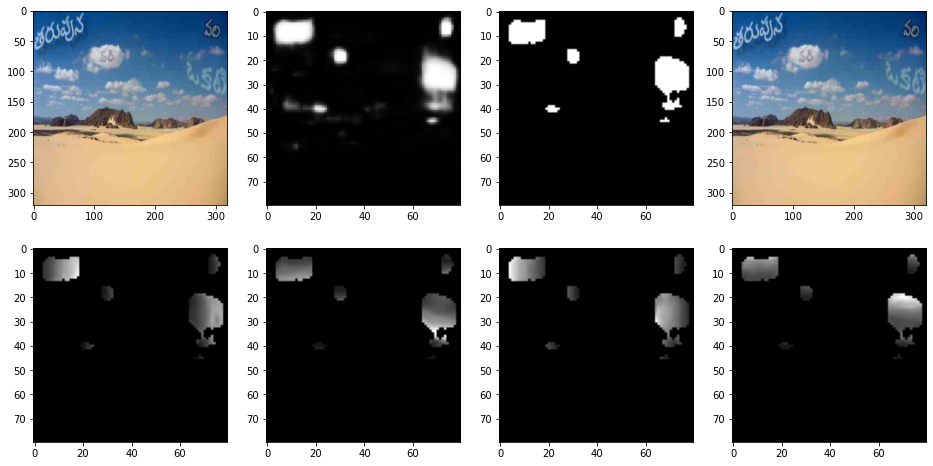

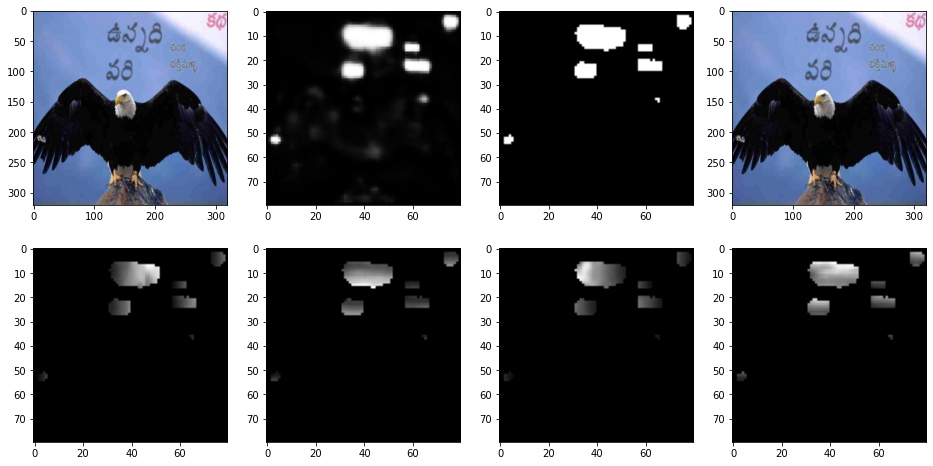

True

In [19]:
visualize_predictions(split='Val', n=5)